<a href="https://colab.research.google.com/github/chanukaDissanayaka/RideFareClassification/blob/master/Ridefare_submission_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#imports

import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import math
from sklearn.preprocessing import Normalizer

from datetime import datetime, timedelta
from pandas import DataFrame

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

import numpy as np

RANDOM_SEED = 4

In [0]:
dataframe = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

dataframe.isna().sum(axis = 0)
#dataframe = dataframe.fillna(method='ffill')
#dataframe = dataframe.dropna()

tripid                         0
additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         137
label                          0
dtype: int64

In [0]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
dframe = imp_mean.fit_transform(dataframe)

In [0]:


def haversine_distance(lat1, lon1, lat2, lon2):
  r = 6371
  phi1 = np.radians(lat1)
  phi2 = np.radians(lat2)
  d_phi = np.radians(lat2-lat1)
  d_lambda = np.radians(lon2-lon1)

  a = np.sin(d_phi /2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda/2)**2
  res = r*(2* np.arctan2(np.sqrt(a), np.sqrt(1-a)))

  return np.round(res,2)
  return res

def get_d(p_lat, p_long, d_lat, d_long):
  R = 6373.0

  lat1 = np.radians(p_lat)
  lon1 = np.radians(p_long)
  lat2 = np.radians(d_lat)
  lon2 = np.radians(d_long)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

  distance = R * c
  return distance

mm = dataframe
#mm["distance"] = (((frame['pick_lat']-frame['drop_lat'])**2)+((frame['pick_lon']-frame['drop_lon'])**2)**0.5)

mm["distance"] = haversine_distance(dataframe['pick_lat'],dataframe['drop_lat'],dataframe['pick_lon'],dataframe['drop_lon'])

mm.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct,8928.13
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct,8925.61
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct,8922.14
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct,8920.81
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct,8927.76


In [0]:
def preprocess_train_data(dataframe):
  feature_set = dataframe.iloc[:,1:13]

  features = feature_set

  features['pickup_time'] = pd.to_datetime(features['pickup_time'], format="%m/%d/%Y %H:%M")
  features['drop_time'] = pd.to_datetime(features['drop_time'], format="%m/%d/%Y %H:%M")

  td = features

  td['pickup_time_year'] = td['pickup_time'].dt.year
  td['pickup_time_month'] = td['pickup_time'].dt.month
  td['pickup_time_day'] = td['pickup_time'].dt.day
  td['pickup_time_hour'] = td['pickup_time'].dt.hour
  td['pickup_time_minute'] = td['pickup_time'].dt.minute

  td['drop_time_year'] = td['drop_time'].dt.year
  td['drop_time_month'] = td['drop_time'].dt.month
  td['drop_time_day'] = td['drop_time'].dt.day
  td['drop_time_hour'] = td['drop_time'].dt.hour
  td['drop_time_minute'] = td['drop_time'].dt.minute

  td = td.drop('pickup_time',1)
  td = td.drop('drop_time',1)

  td = get_trip_distance(td)
  td = get_X_distance(td)
  td = get_Y_distance(td)
  td = get_pick_XY(td)
  td = get_drop_XY(td)
  td = get_peak(td)
  td = set_time_of_the_day(td)
  td =  transform_hour(td)
  td = crossFeaturesFarePickTime(td)

  return td

def get_labels(dataframe):
  label_set = dataframe.iloc[:, 13:14]

  rev_label_set = label_set.replace({'correct':'incorrect', 'incorrect':'correct'})

  encoder = LabelEncoder()
  encoder.fit(rev_label_set)
  labels = encoder.transform(rev_label_set)
  return labels

def set_time_of_the_day(cleaned_train_set):
  newFrame = cleaned_train_set
  tt = newFrame

  d0_index = newFrame[(newFrame['pickup_time_hour']>=0) & (newFrame['pickup_time_hour'] < 6 )].index
  tt.loc[d0_index,'time_of_day']=0

  d1_index = newFrame[(newFrame['pickup_time_hour']>=6) & (newFrame['pickup_time_hour'] < 12 )].index
  tt.loc[d1_index,'time_of_day']=1

  d2_index = newFrame[(newFrame['pickup_time_hour']>=12) & (newFrame['pickup_time_hour'] < 18 )].index
  tt.loc[d2_index,'time_of_day']=2

  d3_index = newFrame[(newFrame['pickup_time_hour']>=18) & (newFrame['pickup_time_hour'] < 24 )].index
  tt.loc[d3_index,'time_of_day']=3

  return tt

def haversine_distance(lat1, lon1, lat2, lon2):
  r = 6371
  phi1 = np.radians(lat1)
  phi2 = np.radians(lat2)
  d_phi = np.radians(lat2-lat1)
  d_lambda = np.radians(lon2-lon1)

  a = np.sin(d_phi /2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda/2)**2
  res = r*(2* np.arctan2(np.sqrt(a), np.sqrt(1-a)))

  return np.round(res,2)
  return res

def get_trip_distance(frame):
  newFrame = frame
  newFrame["distance"] = haversine_distance(frame['pick_lat'],frame['drop_lat'],frame['pick_lon'],frame['drop_lon'])
  return newFrame

def get_X_distance(frame):
  newFrame = frame
  newFrame["distance_X"] = ((frame['pick_lat']-frame['drop_lat']))
  return newFrame

def get_Y_distance(frame):
  newFrame = frame
  newFrame["distance_Y"] = ((frame['pick_lon']-frame['drop_lon']))
  return newFrame

def get_pick_XY(frame):
  newFrame = frame
  newFrame["pick_X"] = np.cos(frame['pick_lat'])* np.cos(frame['pick_lon'])
  newFrame["pick_Y"] = np.cos(frame['pick_lat'])* np.sin(frame['pick_lon'])
  return newFrame

def get_drop_XY(frame):
  newFrame = frame
  newFrame["drop_X"] = np.cos(frame['drop_lat'])* np.cos(frame['drop_lon'])
  newFrame["drop_Y"] = np.cos(frame['drop_lat'])* np.sin(frame['drop_lon'])
  return newFrame

def get_peak(frame):
  newFrame = frame
  newFrame['peak'] = 0

  d0_index = newFrame[(newFrame['pickup_time_hour']>=7) & (newFrame['pickup_time_hour'] < 10 )].index
  newFrame.loc[d0_index,'peak']=1

  d1_index = newFrame[(newFrame['pickup_time_hour']>=4) & (newFrame['pickup_time_hour'] < 8 )].index
  newFrame.loc[d1_index,'peak']=1

  return newFrame

def transform_hour(frame):
  newFrame = frame
  newFrame["pick_hour_sin"] = np.sin(np.radians(3*frame['pickup_time_hour']))
  newFrame["drop_hour_sin"] = np.sin(np.radians(3*frame['drop_time_hour']))

  newFrame["pick_hour_cos"] = np.cos(np.radians(3*frame['pickup_time_hour']))
  newFrame["drop_hour_cos"] = np.cos(np.radians(3*frame['drop_time_hour']))
  return newFrame

def crossFeaturesFarePickTime(frame):
  newFrame = frame
  newFrame['fareXpick_time'] = newFrame['fare']*newFrame['pickup_time_hour']
  return newFrame
  

In [0]:
cleaned_train_set = preprocess_train_data(dataframe)

labels = get_labels(dataframe)
cleaned_train_set.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,peak,time_of_day,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,fareXpick_time
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,2019,11,1,0,20,2019,11,1,0,34,8928.13,-0.04078,0.0210,-0.175519,-0.818213,-0.187363,-0.791950,0,0.0,0.000000,0.000000,1.000000,1.000000,0.00
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,2019,11,1,0,56,2019,11,1,1,9,8925.61,-0.02784,0.0061,-0.173513,-0.805325,-0.174935,-0.788535,0,0.0,0.000000,0.052336,1.000000,0.998630,0.00
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,2019,11,1,1,8,2019,11,1,1,26,8922.14,-0.02830,-0.0495,-0.197078,-0.786528,-0.154631,-0.778754,0,0.0,0.052336,0.052336,0.998630,0.998630,301.64
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,2019,11,1,2,27,2019,11,1,2,37,8920.81,-0.00178,-0.0076,-0.175582,-0.781100,-0.169414,-0.781369,0,0.0,0.104528,0.104528,0.994522,0.994522,164.60
4,NaN,NaN,NaN,NaN,NaN,6.87441,79.8615,6.84478,79.9290,358.39,2019,11,1,3,34,2019,11,1,3,51,8927.76,0.02963,-0.0675,-0.204695,-0.804630,-0.152875,-0.832487,0,0.0,0.156434,0.156434,0.987688,0.987688,1075.17


In [0]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
dframe = imp_mean.fit_transform(cleaned_train_set)
k = cleaned_train_set.keys()
imputed_train_set = cleaned_train_set
imputed_train_set[k] = dframe

In [0]:
imputed_train_set.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,peak,time_of_day,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,fareXpick_time
0,10.500000,834.000000,56.000000,0.000000,64.000000,6.86252,79.8993,6.90330,79.8783,270.32,2019.0,11.0,1.0,0.0,20.0,2019.0,11.0,1.0,0.0,34.0,8928.13,-0.04078,0.0210,-0.175519,-0.818213,-0.187363,-0.791950,0.0,0.0,0.000000,0.000000,1.000000,1.000000,0.00
1,10.500000,791.000000,47.000000,0.000000,134.000000,6.88589,79.8984,6.91373,79.8923,197.85,2019.0,11.0,1.0,0.0,56.0,2019.0,11.0,1.0,1.0,9.0,8925.61,-0.02784,0.0061,-0.173513,-0.805325,-0.174935,-0.788535,0.0,0.0,0.000000,0.052336,1.000000,0.998630,0.00
2,10.500000,1087.000000,80.000000,0.000000,61.000000,6.90839,79.8651,6.93669,79.9146,301.64,2019.0,11.0,1.0,1.0,8.0,2019.0,11.0,1.0,1.0,26.0,8922.14,-0.02830,-0.0495,-0.197078,-0.786528,-0.154631,-0.778754,0.0,0.0,0.052336,0.052336,0.998630,0.998630,301.64
3,10.500000,598.000000,271.000000,15.663800,68.000000,6.92570,79.8895,6.92748,79.8971,82.30,2019.0,11.0,1.0,2.0,27.0,2019.0,11.0,1.0,2.0,37.0,8920.81,-0.00178,-0.0076,-0.175582,-0.781100,-0.169414,-0.781369,0.0,0.0,0.104528,0.104528,0.994522,0.994522,164.60
4,13.719651,1702.858077,629.074231,32.057666,112.466832,6.87441,79.8615,6.84478,79.9290,358.39,2019.0,11.0,1.0,3.0,34.0,2019.0,11.0,1.0,3.0,51.0,8927.76,0.02963,-0.0675,-0.204695,-0.804630,-0.152875,-0.832487,0.0,0.0,0.156434,0.156434,0.987688,0.987688,1075.17


In [0]:
numeric_cols = ['meter_waiting','meter_waiting_fare','meter_waiting_till_pickup',
               'additional_fare','duration','pick_lat','pick_lon','drop_lat','drop_lon',
               'fare','pickup_time_day','pickup_time_hour','pickup_time_minute']

numeric_cols = ['additional_fare','duration','meter_waiting','meter_waiting_fare',
                'meter_waiting_till_pickup','fare','distance']

categorical_cols = []
total = len(numeric_cols)+len(categorical_cols)
print(total)

7


In [0]:
X_train, X_eval, Y_train, Y_eval = train_test_split(
    imputed_train_set,
    labels,
    test_size=0.20,
    shuffle=True,
    stratify=labels,
    random_state=RANDOM_SEED
)

In [0]:
numeric_preprocessing_steps = Pipeline([
    ('minmax_scaler', MinMaxScaler()),
    #('normalizer', Normalizer())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    #('imputer', SimpleImputer(strategy='mean')),
    ])
categorical_transformer_ordinal = Pipeline(steps=[
    ('ordinal', OrdinalEncoder()),
    #('imputer', SimpleImputer(strategy='constant'))
    ])


preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("categorical", categorical_transformer_ordinal, categorical_cols)
    ],
    remainder = "drop"
)

data_pipeline = Pipeline([
    ("preprocessor", preprocessor)
])

In [0]:
X_train.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,distance,distance_X,distance_Y,pick_X,pick_Y,drop_X,drop_Y,peak,time_of_day,pick_hour_sin,drop_hour_sin,pick_hour_cos,drop_hour_cos,fareXpick_time
4102,10.5,1197.0,110.0,0.0000,44.0,6.87054,79.8889,6.89072,79.9224,262.51,2019.0,11.0,24.0,12.0,50.0,2019.0,11.0,24.0,13.0,10.0,8928.01,-0.02018,-0.0335,-0.183047,-0.812034,-0.153623,-0.806558,0.0,2.0,0.587785,0.629320,0.809017,0.777146,3150.12
516,10.5,850.0,178.0,10.2884,23.0,6.91011,79.8795,6.88727,79.8616,157.71,2019.0,11.0,4.0,10.0,48.0,2019.0,11.0,4.0,11.0,2.0,8922.31,0.02284,0.0179,-0.185502,-0.788304,-0.202832,-0.797637,0.0,1.0,0.500000,0.544639,0.866025,0.838671,1577.10
15001,10.5,1027.0,106.0,0.0000,125.0,6.91261,79.8538,6.86957,79.8808,237.76,2020.0,1.0,21.0,9.0,57.0,2020.0,1.0,21.0,10.0,14.0,8921.97,0.04304,-0.0270,-0.205324,-0.781856,-0.189741,-0.811048,1.0,1.0,0.453990,0.500000,0.891007,0.866025,2139.84
7187,10.5,455.0,6.0,0.3498,9.0,6.86780,79.8855,6.85186,79.8762,115.22,2019.0,12.0,9.0,21.0,4.0,2019.0,12.0,9.0,21.0,12.0,8928.07,0.01594,0.0093,-0.186146,-0.812884,-0.195716,-0.819571,0.0,3.0,0.891007,0.891007,0.453990,0.453990,2419.62
5762,10.5,2494.0,293.0,0.0000,293.0,6.98839,79.8914,6.90811,79.9603,593.97,2019.0,12.0,2.0,18.0,48.0,2019.0,12.0,2.0,19.0,29.0,8915.55,0.08028,-0.0689,-0.165592,-0.743256,-0.121446,-0.801863,0.0,3.0,0.809017,0.838671,0.587785,0.544639,10691.46


In [0]:
data_pipeline.fit(X_train)
d_train = data_pipeline.transform(X_train)
d_eval = data_pipeline.transform(X_eval)

In [0]:
print(d_train.shape, Y_train.shape)

(13740, 7) (13740,)


In [0]:
d_train[2]

array([2.32908922e-02, 2.26275249e-03, 2.33660311e-04, 0.00000000e+00,
       1.04655057e-02, 4.86289651e-01, 8.30130874e-01, 8.82357635e-03,
       8.34127144e-01, 9.00000000e+00])

In [0]:
from sklearn.utils.class_weight import compute_sample_weight
sample_w = compute_sample_weight(class_weight={0:5, 1:1}, y=Y_train)

In [0]:
from sklearn.utils.class_weight import compute_sample_weight
sample_w = compute_sample_weight(class_weight={0:0.1, 1:0.90}, y=Y_train)


In [0]:
#drop lat lon all
from sklearn.ensemble import GradientBoostingClassifier

gbclf = GradientBoostingClassifier(random_state=0, n_estimators = 1000, max_depth =8, subsample = 1.0,
                                   verbose = 1, learning_rate = 0.1)
gbclf.fit(d_train, Y_train, sample_w)
gbclf.score(d_eval, Y_eval)

      Iter       Train Loss   Remaining Time 
         1           1.1872            1.32m
         2           1.0997            1.20m
         3           1.0290            1.19m
         4           0.9703            1.16m
         5           0.9187            1.15m
         6           0.8716            1.14m
         7           0.8334            1.15m
         8           0.7981            1.14m
         9           0.7654            1.14m
        10           0.7369            1.16m
        20           0.5310            1.13m
        30           0.4209            1.11m
        40           0.3541            1.09m
        50           0.3130            1.07m
        60           0.2764            1.06m
        70           0.2472            1.05m
        80           0.2241            1.04m
        90           0.2043            1.02m
       100           0.1868            1.01m
       200           0.0770           53.04s
       300           0.0351           46.27s
       40

0.9423748544819558

In [0]:
data_pipeline.fit(imputed_train_set)
d_all = data_pipeline.transform(imputed_train_set)
y_all = labels
print(d_all.shape, y_all.shape)

(17176, 7) (17176,)


In [0]:
from keras import metrics
import tensorflow as tf

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:

def create_baseline():
	model = Sequential()
	model.add(Dense(10, input_dim=8, activation='relu'))
	model.add(Dense(4, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[tf.keras.metrics.Precision(), 
                        tf.keras.metrics.Recall()])
	return model

In [0]:
model = Sequential()
model.add(Dense(10, input_dim=8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[tf.keras.metrics.Precision(), 
                      tf.keras.metrics.Recall()])


In [0]:

#estimator = KerasClassifier(build_fn=create_baseline, epochs=500, batch_size=100, verbose=2)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(model, d_all, y_all, cv=kfold, scoring ='f1')
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [0]:
model = Sequential()
model.add(Dense(10, input_dim=7, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[tf.keras.metrics.Precision(), 
                      tf.keras.metrics.Recall()])

In [0]:
model.fit(d_train, Y_train,batch_size=100, epochs=3500)

Epoch 1/3500
13740/13740 [==============================] - 1s 39us/step - loss: 0.6037 - precision: 0.7714 - recall: 0.5834
Epoch 2/3500
13740/13740 [==============================] - 0s 13us/step - loss: 0.3879 - precision: 0.9024 - recall: 0.9016
Epoch 3/3500
13740/13740 [==============================] - 0s 13us/step - loss: 0.3253 - precision: 0.9017 - recall: 0.9423
Epoch 4/3500
13740/13740 [==============================] - 0s 13us/step - loss: 0.3207 - precision: 0.9018 - recall: 0.9590
Epoch 5/3500
13740/13740 [==============================] - 0s 14us/step - loss: 0.3200 - precision: 0.9018 - recall: 0.9682
Epoch 6/3500
13740/13740 [==============================] - 0s 14us/step - loss: 0.3194 - precision: 0.9021 - recall: 0.9740
Epoch 7/3500
13740/13740 [==============================] - 0s 14us/step - loss: 0.3188 - precision: 0.9020 - recall: 0.9780
Epoch 8/3500
13740/13740 [==============================] - 0s 14us/step - loss: 0.3182 - precision: 0.9020 - recall: 0.9810


In [0]:
pm = model.predict_classes(d_eval)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

print(f1_score(Y_eval, pm, average='micro'))
confusion_matrix(Y_eval,pm)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

print(f1_score(Y_eval, pm, average='micro'))
confusion_matrix(Y_eval,pm)

0.9455762514551804


array([[ 197,  139],
       [  48, 3052]])

In [0]:
pm

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

print(f1_score(Y_eval, pm, average='micro'))
confusion_matrix(Y_eval,pm)

0.9213317619328226


array([[  47,  258],
       [   9, 3080]])

      Iter       Train Loss   Remaining Time 
         1           1.1572            2.16m
         2           1.0658            2.15m
         3           0.9959            2.17m
         4           0.9346            2.20m
         5           0.8785            2.20m
         6           0.8291            2.22m
         7           0.7849            2.22m
         8           0.7420            2.22m
         9           0.7131            2.22m
        10           0.6771            2.23m
        11           0.6492            2.23m
        12           0.6188            2.23m
        13           0.5902            2.23m
        14           0.5627            2.23m
        15           0.5439            2.24m
        16           0.5264            2.24m
        17           0.5092            2.25m
        18           0.4943            2.26m
        19           0.4806            2.26m
        20           0.4655            2.25m
        21           0.4539            2.25m
        2

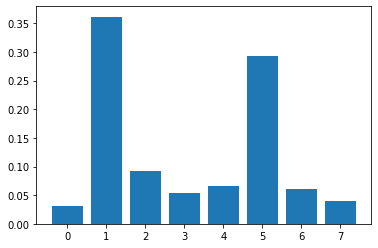

In [0]:
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

gbclf.fit(d_train, Y_train, sample_w)
importance = gbclf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

(16968, 15) (16968,)


In [0]:

from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

model = DecisionTreeRegressor()
# fit the model
model.fit(d_all, y_all)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [0]:
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

model = LinearRegression()
model.fit(d_all, y_all)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [0]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define dataset

model = LogisticRegression()
# fit the model
model.fit(d_all, y_all)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

      Iter       Train Loss   Remaining Time 
         1           0.5142            2.65m
         2           0.4741            2.63m
         3           0.4467            2.63m
         4           0.4229            2.64m
         5           0.4038            2.63m
         6           0.3866            2.63m
         7           0.3734            2.62m
         8           0.3607            2.64m
         9           0.3483            2.64m
        10           0.3373            2.64m
        11           0.3290            2.64m
        12           0.3221            2.63m
        13           0.3133            2.63m
        14           0.3053            2.63m
        15           0.2955            2.62m
        16           0.2877            2.62m
        17           0.2831            2.62m
        18           0.2792            2.61m
        19           0.2709            2.61m
        20           0.2647            2.60m
        21           0.2609            2.60m
        2

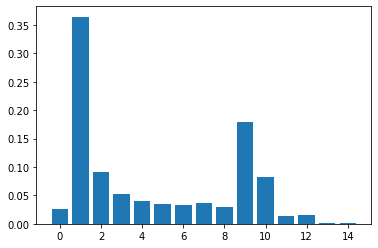

In [0]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

model = RandomForestClassifier()

gbclf.fit(d_all, y_all)
# get importance
importance = gbclf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [0]:
X_train.keys()

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'pick_lat', 'pick_lon', 'drop_lat',
       'drop_lon', 'fare', 'pickup_time_year', 'pickup_time_month',
       'pickup_time_day', 'pickup_time_hour', 'pickup_time_minute',
       'drop_time_year', 'drop_time_month', 'drop_time_day', 'drop_time_hour',
       'drop_time_minute', 'distance', 'distance_X', 'distance_Y', 'pick_X',
       'pick_Y', 'drop_X', 'drop_Y', 'peak', 'time_of_day'],
      dtype='object')

In [0]:
numeric_cols = ['additional_fare','duration','meter_waiting','meter_waiting_fare',
                'meter_waiting_till_pickup','pick_lat','pick_lon','drop_lat','drop_lon',
               'fare','distance']
categorical_cols = ['pickup_time_hour','drop_time_hour','peak', 'time_of_day']

In [0]:
cleaned_test_data = preprocess_train_data(test)

test_set = data_pipeline.transform(cleaned_test_data)

In [0]:
test_set.shape

(8576, 7)

In [0]:
preds = model.predict_classes(test_set)
print(preds)

[[1]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]


In [0]:
preds.shape

(8576, 1)

In [0]:
output = pd.DataFrame(test,columns=['tripid'])
output['prediction'] = preds
output.head()

,tripid,prediction
0,213284604,1
1,213286352,0
2,213293973,1
3,213294622,1
4,213298687,1


In [0]:
output.to_csv('/content/Ridefare_submission_13.csv',index=False)

In [0]:
base = gbclf.predict(d_eval)
#print("keras", f1_score(Y_eval, eval_predict, average='micro'))
print("base", f1_score(Y_eval, base, average='micro'))

from sklearn.metrics import confusion_matrix

results = gbclf.predict(d_eval)
confusion_matrix(Y_eval, results)

base 0.9490276959340012


array([[ 170,  135],
       [  38, 3051]])

In [0]:
k =0
for i in pred_proba:
  print("%0.5f"%i[0],"%0.4f"%i[1], Y_eval[k])
  k = k+1

In [0]:
pred_proba = gbclf.predict_proba(d_eval)

threshold = 0.3

preds = (pred_proba [:,1] >= threshold).astype('int')

In [0]:
base = gbclf.predict(d_eval)
#print("keras", f1_score(Y_eval, eval_predict, average='micro'))
print("base", f1_score(Y_eval, base, average='micro'))

from sklearn.metrics import confusion_matrix

results = gbclf.predict(d_eval)
confusion_matrix(Y_eval, results)

In [0]:
pred_proba = gbclf.predict_proba(d_eval)

threshold = 0.05

preds = (pred_proba [:,0] <= threshold).astype('int')

In [0]:
print(preds)
print("base", f1_score(Y_eval, preds, average='micro'))
confusion_matrix(Y_eval, preds)

[1 0 1 ... 1 1 1]
base 0.940777843252799


array([[ 200,  105],
       [  96, 2993]])

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0, class_weight={0:1, 1:8}, max_depth = 20)
clf.fit(d_train, Y_train)
clf.score(d_eval, Y_eval)

0.9281084266352386

In [0]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

test = SelectKBest(score_func=f_classif, k=17)
fit = test.fit(X_train, Y_train)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features_selected = fit.transform(cleaned_train_set)

k = cleaned_train_set.keys()
j =0
for i in fit.scores_:
  print (i, k[j])
  j = j+1

[2.560e+01 1.501e+02 1.365e+02 1.262e+02 1.618e+01 4.756e+00 1.069e+01
 4.670e-01 6.644e+00 4.090e+02 3.445e-01 1.521e-01 4.540e-01 2.967e-01
 3.661e-01 9.497e-05 1.896e-01]
25.601700516148178 additional_fare
150.1423482323858 duration
136.53814018608236 meter_waiting
126.15291654442362 meter_waiting_fare
16.176969168253855 meter_waiting_till_pickup
4.755913729479669 pick_lat
10.68640597221555 pick_lon
0.46699771908048066 drop_lat
6.644427453624097 drop_lon
409.0290439880105 fare
0.3444733818253683 pickup_time_day
0.15214708901589488 pickup_time_hour
0.45403506787917486 pickup_time_minute
0.2967370493315319 drop_time_day
0.3660508242748645 drop_time_hour
9.497351291964044e-05 drop_time_minute
0.18958475782896403 time_of_day
